In [2]:
!pip install torch torchvision
!pip install matplotlib numpy pillow requests

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/e5/35/0c52d708144c2deb595cd22819a609f78fdd699b95ff6f0ebcd456e3c7c1/torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata
  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/36/63/0722e153fd27d64d5b0af45b5c8cb0e80b35a68cf0130303bc9a8bb095c7/torchvision-0.21.0-cp312-cp312-manylinux1_x86_64.whl.metadata
  Using cached torchvision-0.21.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.1 kB)
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/89/ec/00d68c4ddfedfe64159999e5f8a98fb8442729a63e2077eb9dcd89623d27/filelock-3.17.0-py3-none-any.whl.metadata
  Using cached filelock-3.17.0-py3-none-any.whl.metadata (2.9 kB)
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/b9/54/dd730b32ea14ea797530a4479b2ed46a

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import datasets, transforms, models
from torchvision.models import VGG16_Weights
from PIL import Image
import requests

In [5]:
# Definiowanie ścieżek do datasetu
data_dir = '/home/bartek/Documents/DataSetTest3'
train_dir = f'{data_dir}/train'
val_dir = f'{data_dir}/val'

In [6]:
classes = ('mug', 'parfum')

In [7]:

# Definicja transformacji dla treningu i walidacji
transform_train = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ładowanie datasetu
training_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
validation_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [8]:
# Funkcja do konwersji tensora na obraz

def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5)) + np.array((0.5))
    image = image.clip(0, 1)
    return image

In [9]:
# Wczytanie modelu
model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
for param in model.features.parameters():
    param.requires_grad = False

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

# Definiowanie funkcji kosztu i optymalizatora
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Trenowanie modelu
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        running_loss += loss.item()

    with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            _, val_preds = torch.max(val_outputs, 1)
            val_running_corrects += torch.sum(val_preds == val_labels.data)
            val_running_loss += val_loss.item()

    epoch_loss = running_loss / len(training_loader.dataset)
    epoch_acc = running_corrects.float() / len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss / len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print(f'Epoch {e+1}: Training loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    print(f'Validation loss: {val_epoch_loss:.4f}, Validation accuracy: {val_epoch_acc:.4f}')


Epoch 1: Training loss: 0.0204, Accuracy: 0.8464
Validation loss: 0.0003, Validation accuracy: 1.0000
Epoch 2: Training loss: 0.0085, Accuracy: 0.9536
Validation loss: 0.0004, Validation accuracy: 0.9884
Epoch 3: Training loss: 0.0085, Accuracy: 0.9536
Validation loss: 0.0002, Validation accuracy: 1.0000
Epoch 4: Training loss: 0.0048, Accuracy: 0.9681
Validation loss: 0.0000, Validation accuracy: 1.0000
Epoch 5: Training loss: 0.0147, Accuracy: 0.9304
Validation loss: 0.0035, Validation accuracy: 0.9884


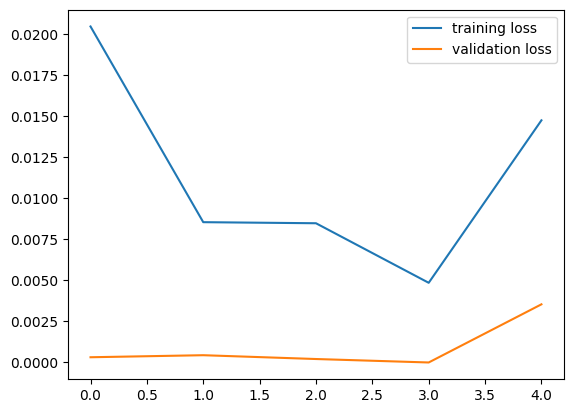

In [10]:

# Wizualizacja wyników treningu
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

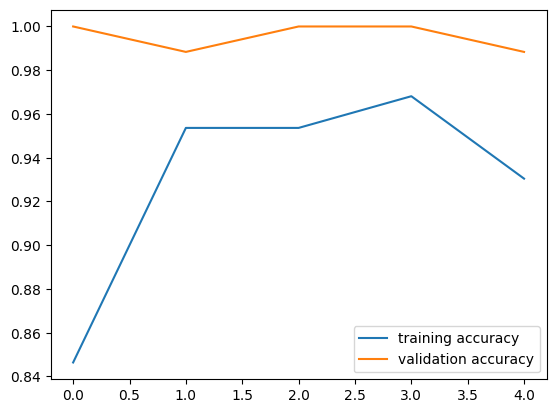

In [11]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()

In [20]:
# Testowanie na jednym obrazie
url = 'https://media.home-you.com/catalog/product/b/5/b5ac083dbae85a50360afeba59f3928f.jpg?store=pl&image-type=image&width=920&height=920'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
img = transform(img).unsqueeze(0)
output = model(img)
_, pred = torch.max(output, 1)
print(f'Przewidziany obiekt: {classes[pred.item()]}')

Przewidziany obiekt: mug
